In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
!pip install pandas numpy torch transformers datasets scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [24]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import itertools

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
link = "https://github.com/dattali18/IR_Assignments/blob/main/Assignment.04/sentences.csv?raw=true"
df = pd.read_csv(link)
texts = df['sentence'].values
labels = df['label'].values

In [7]:
# take a subset of the df 100 from each of the 5 classes
df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)
texts = df['sentence'].values
labels = df['label'].values

In [8]:
# check if the df contains 500 instances
df.groupby('label').count()

,id,sentence,type
label,,,
0,500,476,500
1,500,500,500
2,500,500,500
3,500,500,500
4,500,500,500


In [9]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.15, random_state=42
)

In [10]:
# Create dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [11]:
# Create model class
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(output[0][:, 0, :])
        return self.fc(output)

In [12]:
# Initialize tokenizer and create datasets
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [14]:
# Initialize model and move to GPU
model = SentimentClassifier()
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [15]:
# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

In [16]:
# Training loop
def train_model():
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc='Training'):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [17]:
# Evaluation loop
def evaluate_model():
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs, dim=1)

            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return total_loss / len(val_loader), accuracy

In [18]:
# Training
for epoch in range(n_epochs):
    print(f'\nEpoch {epoch + 1}/{n_epochs}')
    train_loss = train_model()
    val_loss, val_accuracy = evaluate_model()

    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/5


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 17.26it/s]


Training Loss: 0.7418
Validation Loss: 0.2142
Validation Accuracy: 0.9360

Epoch 2/5


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 16.25it/s]


Training Loss: 0.1127
Validation Loss: 0.1060
Validation Accuracy: 0.9733

Epoch 3/5


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 16.16it/s]


Training Loss: 0.0322
Validation Loss: 0.1252
Validation Accuracy: 0.9733

Epoch 4/5


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.45it/s]


Training Loss: 0.0258
Validation Loss: 0.1632
Validation Accuracy: 0.9653

Epoch 5/5


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.85it/s]

Training Loss: 0.0374
Validation Loss: 0.1052
Validation Accuracy: 0.9760


In [ ]:
# Save the model
torch.save(model.state_dict(), 'sentiment_model_v2.pth')

In [19]:
# use the model for testing a sentence

e1 = "The Hamas terroriest have launch a rocket attack to major isreali cities"

In [20]:
# import torch
# from transformers import DistilBertTokenizer

# Assuming the SentimentClassifier class is already defined as provided

# Initialize the model and tokenizer
# model = SentimentClassifier()
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to classify a sentence and get probabilities
def classify_sentence_prob(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model's output
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    return probabilities

# Example usage
# sentence = "This is a sample sentence for classification."
probabilities = classify_sentence_prob(e1)

print("Probabilities for each class:", probabilities)

Probabilities for each class: tensor([[5.6051e-04, 4.2232e-04, 1.2654e-04, 2.6405e-03, 9.9625e-01]],
       device='cuda:0')


In [21]:
# import torch
# from transformers import DistilBertTokenizer

# Assuming the SentimentClassifier class is already defined as provided

# Initialize the model and tokenizer
# model = SentimentClassifier()
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to classify a sentence and get one-hot encoded vector
def classify_sentence_class(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model's output
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Get the predicted class (index of the max probability)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Create a one-hot encoded vector
    one_hot_vector = torch.zeros(probabilities.size(1))
    one_hot_vector[predicted_class] = 1

    return one_hot_vector

# Example usage
# sentence = "This is a sample sentence for classification."
one_hot_vector = classify_sentence_class(e1)

print("One-hot encoded vector for the predicted class:", one_hot_vector)

One-hot encoded vector for the predicted class: tensor([0., 0., 0., 0., 1.])


In [22]:
def one_hot_to_class(one_hot_vector, map_class):
    # Find the index of the maximum value in the one-hot encoded vector
    class_index = torch.argmax(one_hot_vector).item()

    # Get the string representation of the class from the map_class dictionary
    class_string = map_class[class_index]

    return class_string

map_class = {0: 'pro-israeli', 1: 'pro-palestinan', 2: 'neutral', 3: 'anti-isreali', 4: 'anti-palestinian'}

one_hot_to_class(one_hot_vector, map_class)

'anti-palestinian'

In [23]:
def classify_sentence(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Get the model's output
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # get the str of the calss based on the one-hot-encoded vector
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Create a one-hot encoded vector
    one_hot_vector = torch.zeros(probabilities.size(1))
    one_hot_vector[predicted_class] = 1

    map_class = {0: 'pro-israeli', 1: 'pro-palestinan', 2: 'neutral', 3: 'anti-isreali', 4: 'anti-palestinian'}


    return probabilities, one_hot_to_class(one_hot_vector, map_class)

In [31]:
def evaluate_new_data(file_path, model, tokenizer, device):
    # Load the new dataset
    df_new = pd.read_excel(file_path)
    df_new = df_new.dropna(subset=["label"])  # Remove rows with missing labels

    # Label mapping
    label_mapping = {
        "pi": 0, "pp": 1, "n": 2, "ai": 3, "ap": 4
    }
    df_new["label"] = df_new["label"].map(label_mapping).astype(int)

    # Ensure required columns exist
    if 'sentence' not in df_new.columns or 'label' not in df_new.columns:
        raise ValueError("The file must contain 'sentence' and 'label' columns.")

    texts = df_new['sentence'].values
    labels = df_new['label'].values

    # Create test dataset
    test_dataset = SentimentDataset(texts, labels, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Model evaluation
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predictions = torch.max(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    print(f'Model Accuracy on New Data: {accuracy:.4f}')

    # Compute classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=label_mapping.keys()))

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, label_mapping)
    plot_class_accuracy(all_labels, all_predictions, label_mapping)

In [26]:
def plot_confusion_matrix(true_labels, predicted_labels, label_mapping):
    cm = confusion_matrix(true_labels, predicted_labels)
    labels = list(label_mapping.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [32]:
def plot_class_accuracy(true_labels, predicted_labels, label_mapping):
    labels = list(label_mapping.keys())
    cm = confusion_matrix(true_labels, predicted_labels)
    correct_counts = np.diag(cm)
    total_counts = cm.sum(axis=1)
    accuracy_per_class = correct_counts / total_counts

    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=accuracy_per_class, palette='viridis')
    plt.ylim(0, 1)
    plt.ylabel("Accuracy per Class")
    plt.xlabel("Label")
    plt.title("Per-Class Accuracy")
    plt.show()

Model Accuracy on New Data: 0.2114
Classification Report:
              precision    recall  f1-score   support

          pi       0.12      0.03      0.05        59
          pp       0.35      0.09      0.15        65
           n       0.50      0.11      0.19        35
          ai       0.24      0.73      0.36        52
          ap       0.04      0.06      0.05        35

    accuracy                           0.21       246
   macro avg       0.25      0.21      0.16       246
weighted avg       0.25      0.21      0.16       246



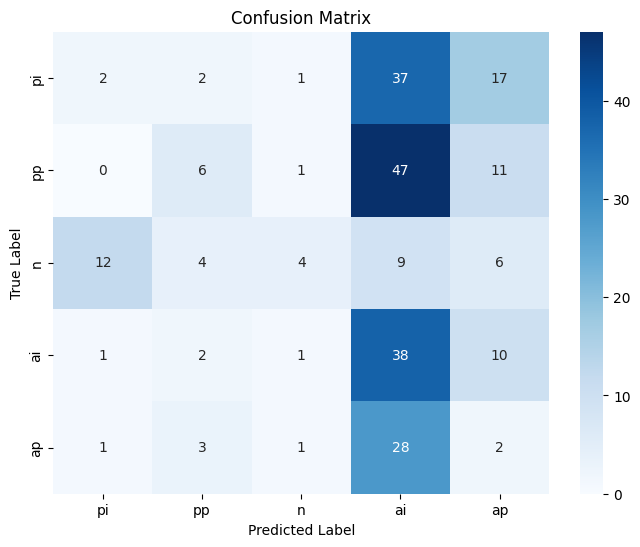

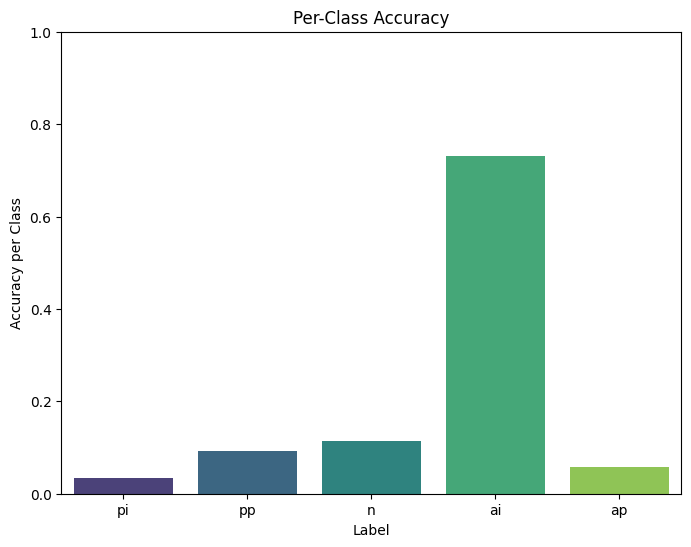

In [33]:
# הפעלת הבדיקה על קובץ המשפטים שסיווגנו עצמאית
evaluate_new_data("/content/Bonus data.xlsx", model, tokenizer, device)